In [1]:
from scipy.constants import *
import matplotlib.pyplot as plt
from scipy.optimize import *
import numpy as np
import sympy as sp
import qucat as qc
phi_0 = h/(2*e) #the flux quantum

# Simulating the SNAIL non-linearity

The goal of this tutorial is to simulate a SNAIL embedded in a superconducting circuit, and eliminate fourth order non-linearities in favor of third-order non-linearities.
The SNAIL is a dipole containing three small Josephson juntions on one side, and a large one on the other side :

<img src="graphics/SNAIL_scheme.png" width = "350"/>

SNAIL scheme taken from *N. E. Frattini, V. V. Sivak, A. Lingenfelter, S. Shankar et M. H. Devoret : Optimizing the Nonlinearity and Dissipation of a SNAIL Parametric Amplifier for Dynamic Range. Physical Review Applied, 10(5):1–17, 2018.*

Its inductive energy writes :

$$U_{SNAIL}(\phi) = -E_J\left(\alpha \cos\phi + 3 \cos \frac{\phi_\text{ext}-\phi}{3}\right)$$

It depends on :
- the flux bias in its loop $\phi_\text{ext}$
- a characteristic Josphson energy $E_J$
- a characteristic coeeficient $\alpha$

For a given $\phi_\text{ext}$, $E_J$ and $\alpha$, one can find the minimum of this inductive energy $\phi_{min}$ and develop it around it:

$$U_{SNAIL}|_{\alpha, E, phi_{ext}}(\phi) = \frac{E2}{2}(\phi-\phi_{min})^2 + \frac{E3}{6}(\phi-\phi_{min})^3 + \frac{E4}{24}(\phi-\phi_{min})^4$$

one can then make use of the `NonLinearInductor` component to define this energy term in a QuCAT circuit as follows

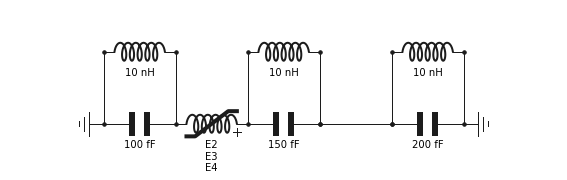

In [2]:
circuit = qc.GUI("circuits/snail.txt", edit=False)

Where the text file `circuits/snail.txt` contains the following:

```
C;-2,-2;-1,-2;1.0e-13;
W;-2,-3;-2,-2;;
W;-1,-3;-1,-2;;
L;-2,-3;-1,-3;1.0e-08;
C;0,-2;1,-2;1.5e-13;
W;0,-3;0,-2;;
W;1,-3;1,-2;;
L;0,-3;1,-3;1.0e-08;
C;2,-2;3,-2;2.0e-13;
W;2,-3;2,-2;;
W;3,-3;3,-2;;
L;2,-3;3,-3;1.0e-08;
G;4,-2;3,-2;;
W;1,-2;2,-2;;
G;-3,-2;-2,-2;;
NonLinearInductor;-1,-2;0,-2;,,;E2,E3,E4
```

The `NonLinearInductor` differs from other components in that it is characterized by multiple parameters (in units of Hertz), such that in this case, its contribution to the Hamiltonian will be

$$U/h = \frac{E2}{2!}\phi^2 + \frac{E3}{3!}\phi^3 + \frac{E4}{4!}\phi^4$$

These parameters are seperated by commas in the graphical user interface, or entered as a list when creating the circuit programmatically.

The following code generates the correct parameters for a given $E_J$ and $\alpha$, and allow for sweeping of $\phi_\text{ext}$

In [3]:
## Parameters for the circuit

order = 4 #order at which the SNAIL will be expanded
alpha = 0.12
L_J = 1e-8
E_J = 1/h*phi_0**2/(4*pi)**2/L_J #the Josephson energy of the small junctions, in Hz

# We use sympy to create the derivatives of the energy 
phi = sp.Symbol("phi")
a = sp.Symbol("a")
E = sp.Symbol("E")
phi_ext = sp.Symbol("phi_ext")

U_sym = -E*(a*sp.cos(phi) + 3*sp.cos((phi_ext-phi)/3))
dnU_sym =[sp.diff(U_sym, phi, i) for i in range(order+1)] # Symbolic expression for the derivatives
dnU = [sp.lambdify([phi, E, a, phi_ext], c) for c in dnU_sym] # creates the python functions for the derivatives

def make_dict_vect(E, a, phi_ext): 
    labels = {}
    for i, c in enumerate(dnU[2::]): #initialisation of the lists
        labels["E"+str(i+2)] = []

    phi_min = [0]

    for c in phi_ext:
        phi_min.append((minimize(dnU[0], 11, 
                                 method = 'L-BFGS-B' , 
                                 bounds = [(-1, 7*np.pi)],args = (1, alpha, c)).x)[0]%(6*np.pi))
    phi_min.pop(0)
    
    for i,c in enumerate(phi_min):
        for j, d in enumerate(dnU[2::]):
            labels["E"+str(j+2)] = labels["E"+str(j+2)]+[d(c, E, a, phi_ext[i])]
    return labels

Let's check the evolution of the derivatives at the minimum as a function of $\phi_{ext}$ :

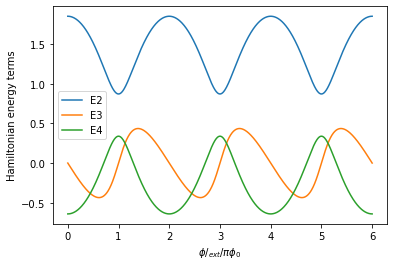

In [4]:
phi_exts = np.linspace(0,6*np.pi, 1000)

labels = make_dict_vect(E_J, alpha, phi_exts) #labels is a dictionnary where each key corresponds to a list of values

plt.plot(phi_exts/np.pi, np.array(labels["E2"])/1e9, label = "E2")
plt.plot(phi_exts/np.pi, np.array(labels["E3"])/1e9,  label = "E3")
plt.plot(phi_exts/np.pi, np.array(labels["E4"])/1e9,  label = "E4")
plt.xlabel(r"$\phi/_{ext}/\pi\phi_0}$")
plt.ylabel(r"Hamiltonian energy terms")
plt.legend()
plt.show()

The unbiased SNAIL has no third order term since it's has a parity in the flux.
Let's look at the frequencies, given by E2 :

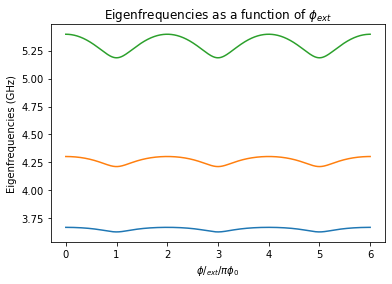

In [5]:
freqs = circuit.eigenfrequencies(**labels)/1e9

plt.xlabel(r"$\phi/_{ext}/\pi\phi_0}$")
plt.ylabel("Eigenfrequencies (GHz)")
plt.title("Eigenfrequencies as a function of $\phi_{ext}$")
[plt.plot(phi_exts/np.pi, np.real(c)) for c in freqs]
plt.show()

They follow the evolution of E2, which is expected.

Let's look at the three waves mixing term :

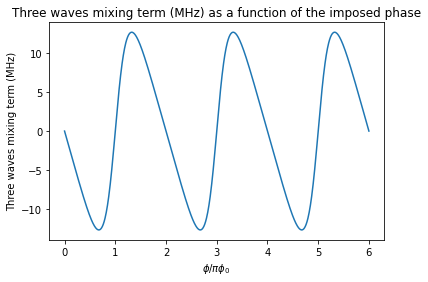

In [6]:
three_waves = circuit.three_waves(0, 1, 2, **labels)/1e6 # In MHz
plt.xlabel(r"$\phi/\pi\phi_0}$")
plt.ylabel("Three waves mixing term (MHz)")
plt.title("Three waves mixing term (MHz) as a function of the imposed phase")
plt.plot(phi_exts/np.pi, np.real(three_waves))
plt.show()

It has the same shape as the E3 term.

And now, the self-Kerr terms : 

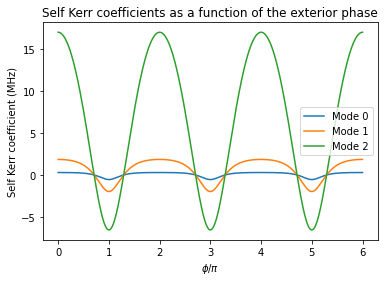

In [7]:
kerr_coeffs = circuit.kerr(**labels)/1e6 # in MHz
for i in range(len(kerr_coeffs)):
    plt.plot(phi_exts/np.pi, np.real(kerr_coeffs[i, i]), label = "Mode "+ str(i))
plt.legend()
plt.xlabel(r"$\phi/\pi}$")
plt.ylabel("Self Kerr coefficient (MHz)")
plt.title("Self Kerr coefficients as a function of the exterior phase")
plt.show()

We can clearly see the existence of the sweet spot, point where all the Kerr terms vanish, but the three waves mixing term still exists, allowing to make a parametric amplifier without beeing limited by the Kerr terms, see *N. E. Frattini, V. V. Sivak, A. Lingenfelter, S. Shankar et M. H. Devoret : Optimizing the Nonlinearity and Dissipation of a SNAIL Parametric Amplifier for Dynamic Range. Physical Review Applied, 10(5):1–17, 2018.*